In [0]:
%matplotlib inline

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, Sampler

import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from os import listdir
from os.path import isfile, join
import time
import copy

from PIL import Image



plt.ion()   # interactive mode

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

PATH = "gdrive/My Drive/Semester_project/"
SUB_PATH =PATH + 'Datas/Ara/'
ANNOTATION_PATH = PATH + 'Datas/Ara/Annotations/'
DATA_PATH =   SUB_PATH + 'Images/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Helper
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in sorted(os.listdir(d))]

## Preprocessing

### Converting filenames into CSV with lables 

Age dataset form [Here](https://susanqq.github.io/UTKFace/)
The labels of each face image is embedded in the file name, formated like 

[age]_[gender]_[race]_[date&time].jpg

In [0]:
df=pd.read_csv(ANNOTATION_PATH + 'val.csv')
classes = df.stage.unique().size  
df

## Get images 


### Data augmentation

### Dataset


In [0]:
class PlantDataset(Dataset):
  def __init__(self, 
               csv_file, 
               root_dir, 
               num_classes, 
               transform=None,
               crop = False):
      """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """

      self.data = pd.read_csv(csv_file)
      self.root_dir = root_dir
      self.transform = transform
      self.num_classes = num_classes
      self.crop= crop

  def __len__(self):
        return len(self.data)

  def __getitem__(self, idx):

      if torch.is_tensor(idx):
          idx = idx.tolist()
        # Get image name 
      img_name = os.path.join(self.root_dir,
                                str(self.data.iloc[idx, 2]))
        
      image = Image.open(img_name)

      if self.crop : 
        vect = (self.data.loc[idx,'x_min'], self.data.loc[idx,'y_min'],
                            self.data.loc[idx,'x_max'], self.data.loc[idx,'y_max'])
        image = image.crop(vect)
      

      label = int(self.data.loc[idx, 'stage'].item()) - 1
      #Creates a vector with 1 util label position followed by zeros
      # Equation 1 Niu paper  
      lev1 = [1]*label
      lev2 = [0]*(self.num_classes - 1 - label)

      levels = lev1 + lev2
      levels = torch.tensor(levels, dtype=torch.float32)


      if self.transform:
          image = self.transform(image)

      return {'image': image,
                'label': label, #label_tensor , 
              'levels' : levels,
                }


In [0]:
class PlantDatasetTest(Dataset):
  def __init__(self, 
               csv_file, 
               root_dir, 
               num_classes, 
                all_file = None, 
               transform=None, 
               crop=False):
      """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """

      self.data = pd.read_csv(csv_file)
      self.all_data = all_file
      self.root_dir = root_dir
      self.transform = transform
      self.num_classes = num_classes
      self.crop= crop

  def __len__(self):
        return len(self.data)

  def __getitem__(self, idx):

      if torch.is_tensor(idx):
          idx = idx.tolist()
        # Get image name 
      img_name = os.path.join(self.root_dir,
                                str(self.data.iloc[idx, 2]))
        
      image = Image.open(img_name)

      if self.crop : 
        vect = (self.data.loc[idx,'x_min'], self.data.loc[idx,'y_min'],
                            self.data.loc[idx,'x_max'], self.data.loc[idx,'y_max'])
        image = image.crop(vect)
      
      neighbor = False
      try : 
        row = self.all_data.loc[self.all_data['filename'] == str(self.data.iloc[idx, 2])].iloc[0,0]
        neighbor = ((self.all_data.loc[row + 1 , 'stage'] == (self.all_data.loc[row  , 'stage'] + 1)) or 
                      (self.all_data.loc[row , 'stage'] == (self.all_data.loc[row + - 1 , 'stage'] + 1)))
      except: 
        neighbor = False

      label = int(self.data.loc[idx, 'stage'].item()) - 1
      #Creates a vector with 1 util label position followed by zeros
      # Equation 1 Niu paper  
      lev1 = [1]*label
      lev2 = [0]*(self.num_classes - 1 - label)
      levels = lev1 + lev2
      levels = torch.tensor(levels, dtype=torch.float32)


      if self.transform:
          image = self.transform(image)

      return {'image': image,
                'label': label, #label_tensor , 
              'levels' : levels,
              'neighbor' : neighbor,
                }


For the test set. 

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Model TODO

Load and finetune the model for classification 

In [0]:
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
model = models.resnet152(pretrained=True)

In [0]:
class OrdinalNN(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()

        self.num_classes = classes
        resnet = models.resnet50(pretrained=pretrained)

        # Select all the layes except le final fully connected one 
        self.features = nn.ModuleList(resnet.children())[:-2]


        # Traform it into a sequencial 
        self.features = nn.Sequential(*self.features)


        self.avgpool =nn.AdaptiveAvgPool2d(1) 

        # Adding new layers 
        in_features = resnet.fc.in_features
 
        self.fc = nn.Linear(in_features , 1, bias = False)
        self.linear_1_bias = nn.Parameter(torch.zeros(self.num_classes-1).float())

        #For special ordinal
        
        # initialize all fc layers to xavier
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight, gain = 1)

    def forward(self, x):

        #Use previous features 

        x = self.features(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        logits = logits + self.linear_1_bias

        #Compute F 
        probas = torch.sigmoid(logits)
        return logits , probas

In [0]:
model_ft = OrdinalNN()

In [0]:
mode = models.resnet50(pretrained=True)
num_ftrs = mode.fc.in_features
mode.fc = nn.Linear(num_ftrs, classes)

## Training and val 

Revoir et comprendre le code 

In [0]:
# Compute the Cumulative score CS 
def CS_loss(y_predict, y_true , T):
  x = torch.abs(y_true - y_predict)
  b = torch.zeros_like(x)
  a = torch.ones_like(x)
  x = torch.where(x<= T, a, b)
  return x #torch.mean(x.type(torch.float32))

In [0]:
def predict(probas):
  #print(probas.size)
  predict_levels = probas > 0.5
  predicted_labels = torch.sum(predict_levels, dim=1)
  return predicted_labels

In [0]:
def train_model(model, 
                data_loader, 
                criterion,
                optimizer, 
                scheduler, 
                num_epochs = 25):
  
    since = time.time()

    val_acc_history = []
    lr_history = []


    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Training mode
            else:
                model.eval()   # Tvaluation mode

            running_loss = 0.0
            running_corrects = 0
            cs_loss = 0
            confusion_matrix = torch.zeros(classes, classes)
            
            for bi, dl in enumerate(data_loader[phase]):
                inputs = dl["image"]
                label = dl["label"]
                levels = dl['levels']
                inputs = inputs.to(device, dtype=torch.float)
                label = label.to(device, dtype=torch.long)
                levels = levels.to(device, dtype= torch.float)

                # zero gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    logits , probas = model(inputs)
                    preds = predict(probas)

                    loss = criterion(probas, levels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                
                for t, p in zip(label.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1

                

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(CS_loss(preds, label, 0))

                cs_loss += torch.sum(CS_loss(preds, label, 1))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            cs_acc = cs_loss.double() /  dataset_sizes[phase]


            print('{} Loss: {:.4f} Acc: {:.4f} Neighbor acc : {:.4f}'.format(
                phase, epoch_loss, epoch_acc, cs_acc))
            print(scheduler.get_last_lr())
            print(confusion_matrix)
            print(confusion_matrix.diag()/confusion_matrix.sum(1))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                lr_history.append(scheduler.get_last_lr())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, lr_history

### Weightning

In [0]:
train = pd.read_csv(ANNOTATION_PATH +'train.csv')
distribution = train.stage.value_counts().sort_index()
distribution = distribution.to_numpy()
S = distribution[::-1].cumsum()[::-1]
S = S[1:]
N = np.full(distribution.size -1 , fill_value = distribution.sum())
M = np.maximum(S, N-S)
importance = np.sqrt(M) / np.max(np.sqrt(M))
importance = torch.from_numpy(importance)
importance = importance.to(device, dtype=torch.float)

In [0]:
IMAGE_SIZE = 224
NUM_CLASSES = classes
BATCH_SIZE = 32
# Hyperparameters
learning_rate = 0.0005
num_epochs = 200


# Augmentation 
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE), (0.5, 1.) , (1,1)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}


train_dataset = PlantDataset(csv_file=ANNOTATION_PATH + 'train.csv' ,
                                   root_dir=DATA_PATH,
                                   num_classes=NUM_CLASSES,
                                   transform=data_transforms['train'],
                                   crop=False)
val_dataset = PlantDataset(csv_file=ANNOTATION_PATH + 'val.csv',
                                   root_dir=DATA_PATH,
                                   num_classes=NUM_CLASSES,
                                   transform=data_transforms['val'], 
                                   crop=False)
image_datasets = {'train' : train_dataset , 
                  'val' : val_dataset}

train_dataset_loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, 
                                             shuffle=False, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [0]:
train_dataset_loader['train']

In [0]:
pop_std0

array([0.08994923, 0.13920698, 0.04700423], dtype=float32)

In [0]:
# push model to device
model_ft = model_ft.to(device)
criterion = nn.BCELoss(weight=importance, reduction='mean')
params = [p for p in model_ft.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [0]:
# Train and evaluate
model_ft, hist, lr_hist = train_model(model_ft, train_dataset_loader, criterion, optimizer, exp_lr_scheduler, num_epochs=75)
torch.save(model_ft.state_dict(), "model.bin")

Epoch 0/74
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


FileNotFoundError: ignored

## 5 times ! 

In [0]:
IMAGE_SIZE = 224
NUM_CLASSES = classes
BATCH_SIZE = 32
# Hyperparameters
learning_rate = 0.0005
num_epochs = 200


# Augmentation 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((112, 112)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((126, 126)),
        transforms.CenterCrop((112,112)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

In [0]:
# Augmentation 
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop((224, 224), (0.5, 1.) , (1,1)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}


In [0]:
train_paths = [{'test': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/test0.csv',
  'train': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/train0.csv',
  'val': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/val0.csv'},
 {'test': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/test1.csv',
  'train': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/train1.csv',
  'val': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/val1.csv'},
 {'test': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/test2.csv',
  'train': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/train2.csv',
  'val': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/val2.csv'},
 {'test': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/test3.csv',
  'train': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/train3.csv',
  'val': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/val3.csv'},
 {'test': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/test4.csv',
  'train': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/train4.csv',
  'val': 'gdrive/My Drive/Semester_project/Datas/Ara/Annotations/val4.csv'}]

In [0]:
for i, path in enumerate(train_paths) : 
  #Importance
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  train = pd.read_csv(path['train'])
  distribution = train.stage.value_counts().sort_index()
  distribution = distribution.to_numpy()
  S = distribution[::-1].cumsum()[::-1]
  S = S[1:]
  N = np.full(distribution.size -1 , fill_value = distribution.sum())
  M = np.maximum(S, N-S)
  importance = np.sqrt(M) / np.max(np.sqrt(M))
  importance = torch.from_numpy(importance)
  importance = importance.to(device, dtype=torch.float)


# Dtatasets 
  train_dataset = PlantDataset(csv_file=path['train'] ,
                                    root_dir=DATA_PATH,
                                    num_classes=NUM_CLASSES,
                                    transform=data_transforms['train'],
                                    crop= True)
  val_dataset = PlantDataset(csv_file=path['val'],
                                    root_dir=DATA_PATH,
                                    num_classes=NUM_CLASSES,
                                    transform=data_transforms['val'], 
                                      crop=True)
  image_datasets = {'train' : train_dataset , 
                    'val' : val_dataset}

  train_dataset_loader = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, 
                                              shuffle=True, 
                                              num_workers=4), 
                          'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=BATCH_SIZE, 
                                              shuffle=False, num_workers=4)}

  dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
  
  model_ft = OrdinalNN()
  model_ft = model_ft.to(device)

  criterion = nn.BCELoss(weight=importance, reduction='mean')
  params = [p for p in model_ft.parameters() if p.requires_grad]
  optimizer_ft = optim.Adam(params ,lr=0.005 , weight_decay=0.0005)

  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

  #criterion = nn.CrossEntropyLoss()


  model_ft, hist, lr_hist = train_model(model_ft, train_dataset_loader, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)
  save_path = SUB_PATH + 'model_ordinal_crop_2' + str(i) + '.bin'

  torch.save(model_ft.state_dict(), save_path)


## Test

In [0]:
TEST_BATCH_SIZE = 128

# Augmentation 
test_transforms =  transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),

    ])

test_dataset = PlantDataset(csv_file=ANNOTATION_PATH + 'test.csv',
                                   root_dir=DATA_PATH,
                                   num_classes=NUM_CLASSES,
                                   transform=test_transforms)

test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=128,
                                             shuffle=False,
                                             num_workers=4)



dataset_sizes = len(test_dataset)

In [0]:
TEST_BATCH_SIZE = 128

# Augmentation 
test_transforms =  transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

In [0]:
test_val = pd.read_csv(ANNOTATION_PATH + 'test.csv')
test_val = test_val['stage'].to_numpy()

In [0]:
test_val = test_val.astype(int)
test_val.size

413

In [0]:
def predict_ordinal(probas):
  #print(probas.size)
  predict_levels = probas > 0.5
  predicted_labels = np.sum(predict_levels)
  return predict_levels, predicted_labels

In [0]:
def CS(y_predict, y_true , T):
  x = np.abs(y_true - y_predict)
  x = np.where(x<= T, 1, 0)
  x = np.count_nonzero(x, axis = 1)
  return np.count_nonzero(x == y_predict.shape[1]) 

In [0]:
test_dataset_loader

In [0]:
#DO NOT USE 
#model_ft.load_state_dict(torch.load("model.bin"))
model = model_ft
model = model.to(device)

for param in model.parameters():
    param.requires_grad = False

model.eval()
running_corrects = 0
test_preds = np.zeros((len(test_dataset), NUM_CLASSES-1))
confusion_matrix = torch.zeros(classes, classes)
tk0 = tqdm(test_dataset_loader)
for i, x_batch in enumerate(tk0):
    x = x_batch["image"]

    vect = x_batch['levels'].numpy()
    pred, _ = model(x.to(device))
    preds = predict(pred)
    for t, p in zip(x_batch['label'].view(-1), predict.view(-1)):
                  confusion_matrix[t, p] += 1
    running_corrects += np.sum(CS(predict, vect, 0))
    test_preds[i * TEST_BATCH_SIZE:(i + 1) * TEST_BATCH_SIZE, :] = pred.detach().cpu().squeeze().numpy()

test_preds.shape
test_preds = predict_ordinal(test_preds)

print(running_corrects / test_val.size) 

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff94e3947b8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff94ed19160>>

NameError: ignored

In [0]:
acc = []
neib_acc = []
true_acc = []
test_acc =[]
matrix = []

preds_values = []
true_values= []
imge = []
neighboring = []

for i, path in enumerate(train_paths) : 
  save_path = SUB_PATH + 'model_ordinal_3' + str(i) + '.bin'
  model_ft.load_state_dict(torch.load(save_path))

  test_dataset = PlantDatasetTest(csv_file=path['test'],
                                   root_dir=DATA_PATH,
                                   num_classes=NUM_CLASSES,
                                    all_file=ANNOTATION_PATH + 'labels.csv',
                                   transform=test_transforms,
                                  crop = False)

  test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=128,
                                             shuffle=False,
                                             num_workers=4)



  dataset_sizes = len(test_dataset)

  model = model_ft
  model = model.to(device)
  confusion_matrix = torch.zeros(classes, classes)
  id_matrix = torch.zeros(classes, classes)



  for param in model.parameters():
      param.requires_grad = False

  model.eval()
  running_corrects = 0
  nei_corrects = 0 
  test_preds = np.zeros(len(test_dataset))
  true_preds = np.zeros(len(test_dataset))

  # To evaluate neighboring classes 
  im = np.zeros((len(test_dataset), 3,224,224))
  neigh = np.zeros(len(test_dataset))

  for i, x_batch in enumerate(test_dataset_loader):
      x = x_batch["image"]
      labels = x_batch['label']
      n = x_batch['neighbor']

      vect = x_batch['levels'].numpy()
      pred, probas = model(x.to(device))
      preds = predict(probas)
      for t, p in zip(labels.view(-1), preds.view(-1)):
                  confusion_matrix[t, p] += 1
 
      test_preds[i * TEST_BATCH_SIZE:(i + 1) * TEST_BATCH_SIZE] = preds.detach().cpu().squeeze().numpy()
      test_val[i * TEST_BATCH_SIZE:(i + 1) * TEST_BATCH_SIZE] = labels.numpy()
      im[i * TEST_BATCH_SIZE:(i + 1) * TEST_BATCH_SIZE] = x
      neigh[i * TEST_BATCH_SIZE:(i + 1) * TEST_BATCH_SIZE] = n

  preds_values.append(test_preds)
  true_values.append(torch.from_numpy(test_val).float().to(device).cpu().squeeze().numpy())
  acc.append(confusion_matrix.diag().sum() / confusion_matrix.sum())
  neib_acc.append(confusion_matrix.diag() / confusion_matrix.sum(1))
  matrix.append(confusion_matrix)
  #neib_acc.append(CS(test_preds, test_val, 1))
  neighboring.append(neigh)


print(acc)
print(neib_acc)
print(matrix)

[tensor(0.6659), tensor(0.6852), tensor(0.6780), tensor(0.6634), tensor(0.7094)]
[tensor([0.3784, 0.6739, 0.6632, 0.6222, 0.8081]), tensor([0.8387, 0.5732, 0.6827, 0.5766, 0.8824]), tensor([0.6000, 0.6429, 0.6437, 0.6055, 0.8469]), tensor([0.7600, 0.5426, 0.7196, 0.4688, 0.9011]), tensor([0.6923, 0.5618, 0.7767, 0.6442, 0.8571])]
[tensor([[14., 19.,  4.,  0.,  0.],
        [ 7., 62., 23.,  0.,  0.],
        [ 1., 14., 63., 17.,  0.],
        [ 0.,  0., 16., 56., 18.],
        [ 0.,  0.,  0., 19., 80.]]), tensor([[26.,  4.,  1.,  0.,  0.],
        [21., 47., 14.,  0.,  0.],
        [ 1., 14., 71., 18.,  0.],
        [ 1.,  3., 30., 64., 13.],
        [ 0.,  0.,  2.,  8., 75.]]), tensor([[21., 13.,  1.,  0.,  0.],
        [14., 54., 16.,  0.,  0.],
        [ 0.,  8., 56., 23.,  0.],
        [ 0.,  0., 18., 66., 25.],
        [ 0.,  0.,  1., 14., 83.]]), tensor([[19.,  6.,  0.,  0.,  0.],
        [23., 51., 20.,  0.,  0.],
        [ 0., 12., 77., 18.,  0.],
        [ 0.,  2., 21., 45., 28

In [0]:
CB91_Grad_BP = ['#2cbdfe', '#2fb9fc', '#33b4fa', '#36b0f8',
                '#3aacf6', '#3da8f4', '#41a3f2', '#449ff0',
                '#489bee', '#4b97ec', '#4f92ea', '#528ee8',
                '#568ae6', '#5986e4', '#5c81e2', '#607de0',
                '#6379de', '#6775dc', '#6a70da', '#6e6cd8',
                '#7168d7', '#7564d5', '#785fd3', '#7c5bd1',
                '#7f57cf', '#8353cd', '#864ecb', '#894ac9',
                '#8d46c7', '#9042c5', '#943dc3', '#9739c1',
                '#9b35bf', '#9e31bd', '#a22cbb', '#a528b9',
                '#a924b7', '#ac20b5', '#b01bb3', '#b317b1']

In [0]:
color =  ['#ffffff', '#e6e9eb', '#cdd3d7', '#b4bec4', '#9ca9b1',
'#85949e', '#6e808c', '#576d7a', '#415a69', '#2a4858' ]

tensor([[14., 19.,  4.,  0.,  0.],
        [ 7., 62., 23.,  0.,  0.],
        [ 1., 14., 63., 17.,  0.],
        [ 0.,  0., 16., 56., 18.],
        [ 0.,  0.,  0., 19., 80.]])
tensor([0.3784, 0.6739, 0.6632, 0.6222, 0.8081])
tensor([0.3784, 0.6739, 0.6632, 0.6222, 0.8081])
tensor([0.6364, 0.6526, 0.5943, 0.6087, 0.8163])
tensor(0.6659)
tensor([[26.,  4.,  1.,  0.,  0.],
        [21., 47., 14.,  0.,  0.],
        [ 1., 14., 71., 18.,  0.],
        [ 1.,  3., 30., 64., 13.],
        [ 0.,  0.,  2.,  8., 75.]])
tensor([0.8387, 0.5732, 0.6827, 0.5766, 0.8824])
tensor([0.8387, 0.5732, 0.6827, 0.5766, 0.8824])
tensor([0.5306, 0.6912, 0.6017, 0.7111, 0.8523])
tensor(0.6852)
tensor([[21., 13.,  1.,  0.,  0.],
        [14., 54., 16.,  0.,  0.],
        [ 0.,  8., 56., 23.,  0.],
        [ 0.,  0., 18., 66., 25.],
        [ 0.,  0.,  1., 14., 83.]])
tensor([0.6000, 0.6429, 0.6437, 0.6055, 0.8469])
tensor([0.6000, 0.6429, 0.6437, 0.6055, 0.8469])
tensor([0.6000, 0.7200, 0.6087, 0.6408, 0.7685])
t

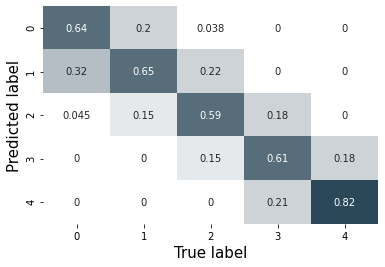

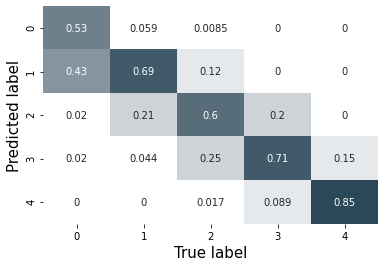

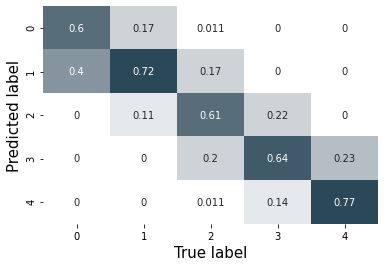

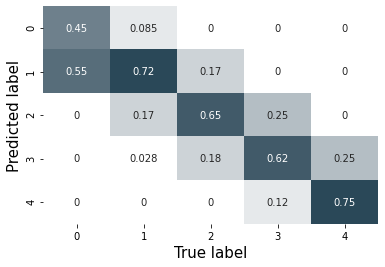

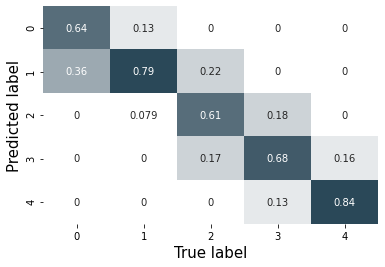

In [0]:
for i, mat in enumerate(matrix): 
  print(mat)
  plt.figure(i)
  sns.heatmap(mat /  mat.sum(0),annot=True, cbar=False, cmap=color)
  plt.xlabel('True label', fontsize = 15) # x-axis label with fontsize 15
  plt.ylabel('Predicted label', fontsize = 15) 
  print(mat.diag() / mat.sum(1))
  precision  =  np.diag(mat)/ mat.T.sum(0)
  recall = np.diag(mat) / mat.sum(0)
  print(precision)
  print(recall)
  print(mat.diag().sum() / mat.sum())

In [0]:
stat = 0
tot = 0
statistiques  = 0
total = 0
vec = [0,0,0,0,0]
vect = [0,0,0,0,0]
SET = 2

for i,x in enumerate(preds_values[SET] ) : 
  statistiques += neighboring[SET][i]
  vect[int(x)] +=  neighboring[SET][i]
  total +=1
  if x != true_values[SET][i] : 

    stat += neighboring[SET][i]
    vec[int(x)] +=  neighboring[SET][i]
    tot +=1


In [0]:
print(stat)
print(statistiques)
print(tot)
print(total)
print(stat/statistiques)
print(tot/total)

print(stat/tot)
print(statistiques/total)

print(vect)
print(vec)


0.0
0.0
147
413
nan
0.3559322033898305
0.0
0.0
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
